# Code Testing Archive (Drafting)

## Table of contents
- [Data generator](#data-generator)
- [Deep learning model](#deep-learning-model)
- [Evaluation](#evaluation)

## Data generator

### Image classification data generator

Total: 76 dataset including
Image: 38
ROI: 38
=====
Train: 76 dataset including
Image: 38
ROI: 38
Class weight: {'Image': 1.0, 'ROI': 1.0}
=====
Test: 0 dataset including


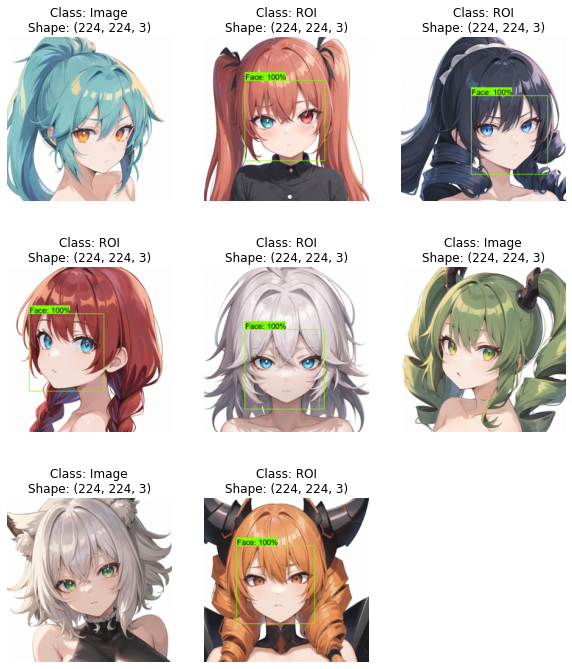

In [1]:
%reset -f

from module.DirectoryProcessor import DirectoryProcessor
from module.image_classification.ImageDataGenerator import ImageDataGenerator
from module.image_classification.ImageVisualizer import ImageVisualizer as vis

# Configuration parameter
CFG = {
    "dataset_dir": "D:\Github Public\DATASET MANAGER\ObjectDetection_SIMPLE",
    "image_size": 224, #
    "extenstions": [".jpg", ".png"],
    "batch": 8,
}

# File path processing
path_list = DirectoryProcessor.get_only_files(CFG["dataset_dir"], CFG["extenstions"])

# Data preparation
data_list = []
for path in path_list:
    if "_ROI" in path:
        data_list.append((path, "ROI"))
    else:
        data_list.append((path, "Image"))

# Data generator instance calling (no augmentation)
generator = ImageDataGenerator(
    input = data_list,
    image_size = CFG["image_size"],
    keep_aspect_ratio = True,
    label_mode = "onehot",
    horizontal_flip = False,
    vertical_flip = False,
    translate_range = None,
    rotation_range = None,
    border_method = "constant",
    validation_split = 0.0,
)

# Generate dataset
train, _ = generator.generate_dataset_from_generator(batch_size=CFG["batch"]) # for low memory
#train, _ = generator.generate_dataset_from_tensor_slices(batch_size=CFG["batch"]) # for high memory

# Visualizing
vis.display_batch(train, ["Image", "ROI"], figsize=(10, 12))

### YOLOv3 data generator

Calculating anchor size ... 3 anchor boxes: [(0.54, 0.54), (0.45, 0.45), (0.49, 0.49)]
CALLING preprocessing function
READ IMAGE ... COMPLETE
READ XML ... COMPLETE
AUGMENTATION: padding -> COMPLETE
Generate annotation labels ... COMPLETE


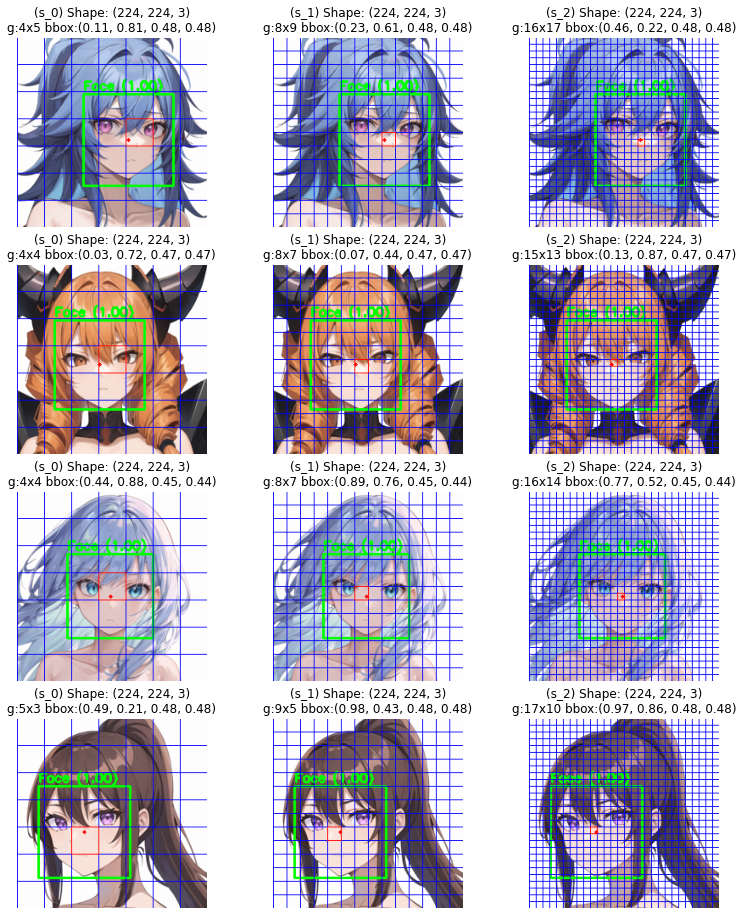

In [2]:
%reset -f

from module.DirectoryProcessor import DirectoryProcessor
from module.object_detection.YOLOv3DataGenerator import YOLOv3DataGenerator
from module.object_detection.YOLOv3Visualizer import YOLOv3Visualizer

# Configuration parameter
CFG = {
    "dataset_dir":  "D:\Github Public\DATASET MANAGER\ObjectDetection_SIMPLE",
    "image_size": 224,
    "anchor": 3,
    "batch": 4,
    "label": ["Face"],
}

# File path processing
path_list = DirectoryProcessor.get_all_files(CFG["dataset_dir"])
path_list = [path for path in path_list if "_ROI" not in path]
path_list = [path for path in path_list if ".csv" not in path]
path_list = [(path_list[i], path_list[i+1]) for i in range (0,len(path_list),2)]

# Data generator instance calling (no augmentation)
data_generator = YOLOv3DataGenerator(
    input=path_list,
    label_list=CFG["label"],
    image_size=CFG["image_size"], 
    num_anchor=CFG["anchor"], 
    horizontal_flip=False, 
    vertical_flip=False, 
    translate_range=None, 
    rotation_range=None,
)

# Generate dataset
dataset = data_generator.generate_dataset(
    batch_size=CFG["batch"],
    drop_reminder=False,
)

# Visualizing
visualizer = YOLOv3Visualizer(CFG["label"])
visualizer.display_batch(dataset, figsize=(13, 16), show_grid=True, show_highlight=True)

Calculating anchor size ... 3 anchor boxes: [(0.54, 0.54), (0.45, 0.45), (0.49, 0.49)]
CALLING preprocessing function
READ IMAGE ... COMPLETE
READ XML ... COMPLETE
AUGMENTATION: translation -> rotation_complex -> horizontal_flip -> padding -> COMPLETE
Generate annotation labels ... COMPLETE


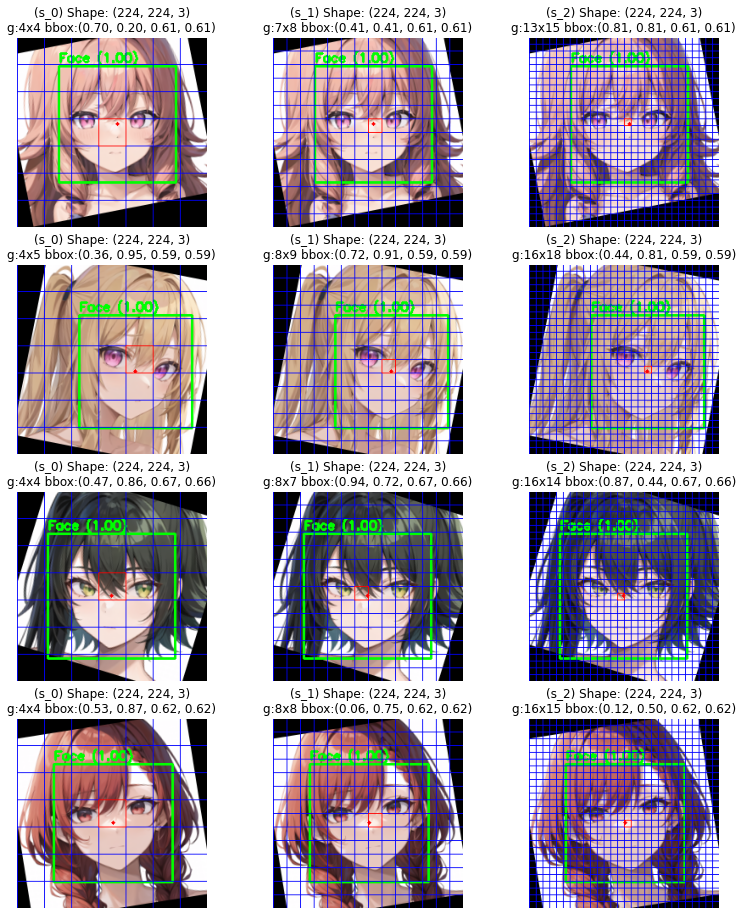

In [3]:
# Data generator instance calling (with augmentation)
data_generator = YOLOv3DataGenerator(
    input=path_list,
    label_list=CFG["label"],
    image_size=CFG["image_size"], 
    num_anchor=CFG["anchor"], 
    horizontal_flip=True, 
    vertical_flip=False, 
    translate_range=0.1, 
    rotation_range=20,
)

# Generate dataset
dataset = data_generator.generate_dataset(
    batch_size=CFG["batch"],
    drop_reminder=False,
)

# Visualizing
visualizer = YOLOv3Visualizer(CFG["label"])
visualizer.display_batch(dataset, figsize=(13, 16), show_grid=True, show_highlight=True)

## Deep learning model

In [1]:
%reset -f

import time
from functools import partial
from module.Initializer import Initializer

## CNN Architecture
from model.GooLeNetModel import Inception_v1, Inception_v1_BN
from model.DenseNetModel import DenseNet121, DenseNet169, DenseNet201, DenseNet264
from model.VGGModel import VGG11, VGG13, VGG16, VGG19
from model.ResnetModel import Resnet18, Resnet34, Resnet50, Resnet101, Resnet152
from model.Res2NetModel import Res2Net50, Res2Net101, Res2Net152
from model.ResNeXtModel import ResNeXt18, ResNeXt34, ResNeXt50, ResNeXt101, ResNeXt152
from model.SqueezeNetModel import SqueezeNet, SqueezeNet_BN, SqueezeNet_SimpleSkip, SqueezeNet_SimpleSkip_BN, SqueezeNet_ComplexSkip, SqueezeNet_ComplexSkip_BN

## Object detection
from model.YOLOv3 import YOLOv3

## Transformer
from model.VisionTransformer import ViTBase, ViTLarge, ViTHuge
from model.CompactConvolutionalTransformer import CCT2, CCT4, CCT6, CCT7, CCT14
from model.VisionTransformer import VisionTransformer as ViT
from model.CompactVisionTransformer import CompactVisionTransformer as CVT
from model.CompactConvolutionalTransformer import CompactConvolutionalTransformer as CCT

class TimeMeasure:
    @staticmethod
    def execute(model):
        print(f"Running model: {model.func.__name__} ... ", end="")
        try:
            start_time = time.time()
            model()
            end_time = time.time()
            elapsed_time = end_time - start_time
            print(f"PASS {elapsed_time:.4f} seconds.")
        except Exception as e:
            error_message = str(e)  # Convert the exception to a string
            print(f"FAILED | Reason:({error_message})")

# initial tensorflow memory growth
Initializer.memory_growth()

# list all model declaration
model_list = [
    # Google Net
    partial(Inception_v1, 224, 2),
    partial(Inception_v1_BN, 224, 2),
    # Dense Net
    partial(DenseNet121, 224, 2),
    partial(DenseNet169, 224, 2),
    partial(DenseNet201, 224, 2),
    partial(DenseNet264, 224, 2),
    # Resnet
    partial(Resnet18, 224, 2),
    partial(Resnet34, 224, 2),
    partial(Resnet50, 224, 2),
    partial(Resnet101, 224, 2),
    partial(Resnet152, 224, 2),
    # Res2Net
    partial(Res2Net50, 224, 2),
    partial(Res2Net101, 224, 2),
    partial(Res2Net152, 224, 2),
    # ResNeXt
    partial(ResNeXt18, 224, 2),
    partial(ResNeXt34, 224, 2),
    partial(ResNeXt50, 224, 2),
    partial(ResNeXt101, 224, 2),
    partial(ResNeXt152, 224, 2), 
    # VGG
    partial(VGG11, 224, 2),
    partial(VGG13, 224, 2),
    partial(VGG16, 224, 2),
    partial(VGG19, 224, 2),
    # SqueezeNet
    partial(SqueezeNet, 224, 2),
    partial(SqueezeNet_BN, 224, 2),
    partial(SqueezeNet_SimpleSkip, 224, 2),
    partial(SqueezeNet_SimpleSkip_BN, 224, 2),
    partial(SqueezeNet_ComplexSkip, 224, 2),
    partial(SqueezeNet_ComplexSkip_BN, 224, 2),
    # YOLO
    partial(YOLOv3, 320, 3, 2),
    partial(YOLOv3, (320, 320), 3, 2),
    # Vision Transformer
    partial(ViT, 224, 32, 2, 12, 768, 12, 3072), # ViT Base
    partial(ViTBase, 224, 32, 2),
    partial(ViTLarge, 224, 32, 2),
    partial(ViTHuge, 224, 32, 2),
    # Compact Vision Transformer
    partial(CVT, 224, 32, 2, 12, 768, 12, 3072),
    # Compact Convolutional Transformer
    partial(CCT, 224, [192, 384, 768], 2, 12, 768, 12, 3072), # ViT base
    partial(CCT2, 224, [32, 64, 128], 2),
    partial(CCT4, 224, [32, 64, 128], 2),
    partial(CCT6, 224, [64, 128, 256], 2),
    partial(CCT7, 224, [64, 128, 256], 2),
    partial(CCT14, 224, [96, 192, 384], 2),
]

# Executing
for model in model_list:
    TimeMeasure.execute(model)


Running model: Inception_v1 ... PASS 2.4694 seconds.
Running model: Inception_v1_BN ... PASS 2.0750 seconds.
Running model: DenseNet121 ... PASS 3.2891 seconds.
Running model: DenseNet169 ... PASS 5.6677 seconds.
Running model: DenseNet201 ... PASS 6.0357 seconds.
Running model: DenseNet264 ... PASS 7.6930 seconds.
Running model: Resnet18 ... PASS 0.6104 seconds.
Running model: Resnet34 ... PASS 1.0138 seconds.
Running model: Resnet50 ... PASS 1.8295 seconds.
Running model: Resnet101 ... PASS 2.8956 seconds.
Running model: Resnet152 ... PASS 4.6478 seconds.
Running model: Res2Net50 ... PASS 2.8725 seconds.
Running model: Res2Net101 ... PASS 5.2776 seconds.
Running model: Res2Net152 ... PASS 7.8574 seconds.
Running model: ResNeXt18 ... PASS 13.9797 seconds.
Running model: ResNeXt34 ... PASS 29.1310 seconds.
Running model: ResNeXt50 ... PASS 31.3186 seconds.
Running model: ResNeXt101 ... PASS 65.5348 seconds.
Running model: ResNeXt152 ... PASS 112.1449 seconds.
Running model: VGG11 ... P

## Evaluation

### Confusion matrix

Loading model ...
Model loaded successfully. No custom Keras layers detected.
Processing class prediction ...
289/289 [====================] - 116s 371ms/batch
Generating confusion matrix ... Complete
Generating text based classification report ... Complete
Complete
Classification Report
              precision    recall  f1-score   support

ILLUSTRATION       1.00      0.98      0.99      3991
       MANGA       0.91      1.00      0.95       622

    accuracy                           0.99      4613
   macro avg       0.95      0.99      0.97      4613
weighted avg       0.99      0.99      0.99      4613

Export figure: Res2Net50SE ... Complete


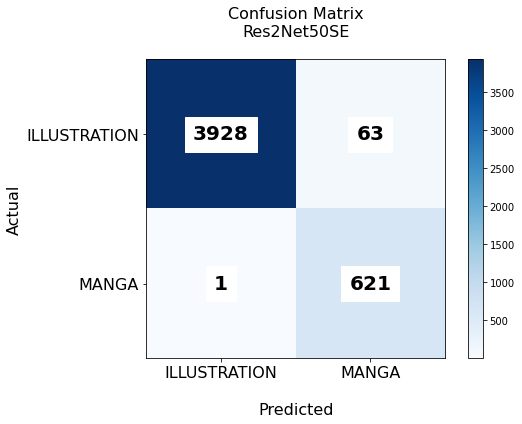

In [2]:
%reset -f

from module.DirectoryProcessor import DirectoryProcessor
from evaluate.ConfusionMatrix import ConfusionMatrix
from pathlib import Path

CFG = {
    "dataset_dir": ".\DATASET MANAGER\Blue Archive",
    "extenstions": [".jpg", ".png"],
    "model1": {"h5":".\export model\Res2Net50SE_224x224_2Class (ILLUST VS MANGA).h5",
               "name":"Res2Net50SE"},
}

def data_maker():
    # File path processing
    data_list = []
    label_set = set()
    path_list = DirectoryProcessor.get_only_files(CFG["dataset_dir"], CFG["extenstions"])

    for path in path_list:
        path_obj = Path(path)
        label = path_obj.parts[-2]
        data_list.append((path, label))
        label_set.add(label)
    
    label_list = list(sorted(label_set))

    return data_list, label_list

data_list, label_list = data_maker()

report = ConfusionMatrix(
    h5_file=CFG["model1"]["h5"],
    model_name=CFG["model1"]["name"],
    data_list=data_list,
    label_list=label_list,
    force_batch=16,
)
report.print_report()
report.export_report()

### Gran-CAM

Load model ... Complete
Generate GranCAM model ... Complete


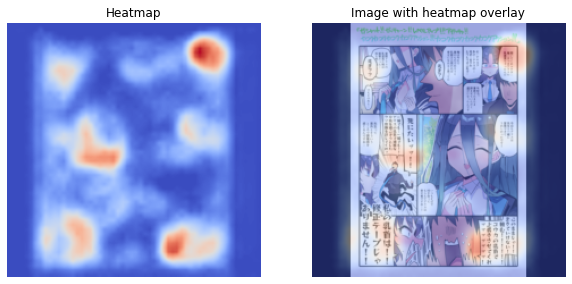

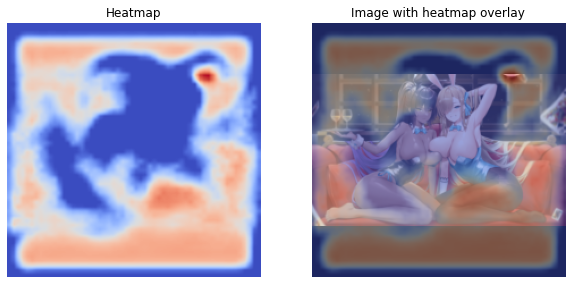

In [1]:
%reset -f

import matplotlib.pyplot as plt
import tensorflow as tf
from evaluate.GranCAM import GranCAM
from module.Initializer import Initializer

# Initializing
Initializer.memory_growth()

# Configuration and Constants
CFG = {
    "h5": ".\export model\Res2Net50SE_224x224_2Class (ILLUST VS MANGA).h5",
}

GRAN_MODEL = GranCAM(CFG["h5"])
_, HEIGHT, WIDTH, _ = GRAN_MODEL.model.input_shape

# Declare functions
def image_resize(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, expand_animations=False)
    image = tf.image.resize(image, (HEIGHT, WIDTH),
                            preserve_aspect_ratio=True,
                            antialias=True)
    image = tf.image.resize_with_pad(image, HEIGHT, WIDTH)
    image = image / 255.0
    
    return image

def generate_heatmap(image_path):
    image = image_resize(image_path)

    heatmap = GRAN_MODEL.generate_heatmap(image, overlay=False)
    overlay = GRAN_MODEL.generate_heatmap(image, overlay=True)

    return heatmap, overlay

def plot_result(heatmap, overlay):
    plt.figure(figsize=(10,8))

    plt.subplot(1, 2, 1)
    plt.imshow(heatmap)
    plt.title('Heatmap')
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title('Image with heatmap overlay')
    plt.axis("off")

# Show results
manga_heatmap, manga_overlay = generate_heatmap('samples\GranCAM\MANGA.jpg')
illust_heatmap, illust_overlay = generate_heatmap('samples\GranCAM\ILLUSTRATION.jpg')
plot_result(manga_heatmap, manga_overlay)
plot_result(illust_heatmap, illust_overlay)